In [44]:
import os
import os.path
import sys 

from pathlib import Path
from glob import glob
from random import choice

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.5.0


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from ResidualAttentionModel import ResidualAttentionModel

In [4]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# data set


* [natural images dataset](https://www.kaggle.com/prasunroy/natural-images)

* https://www.kaggle.com/prasunroy/natural-images

In [5]:
# loading the directories 
datapath = "D:\\programing\\DataSets\\Classification\\natural_images"
dataset_path = Path(datapath)
list(dataset_path.iterdir())

[WindowsPath('D:/programing/DataSets/Classification/natural_images/data'),
 WindowsPath('D:/programing/DataSets/Classification/natural_images/natural_images')]

In [6]:
folders = glob(datapath+"/natural_images/*")
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 8


In [15]:
input_shape = (128,128,3)

In [17]:
training_datagen = ImageDataGenerator(
                                    rescale=1./255,   
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.2)

training_generator = training_datagen.flow_from_directory( datapath+"/natural_images", target_size = input_shape[0:2], batch_size = 32, class_mode = 'categorical', subset='training')
validation_generator = training_datagen.flow_from_directory( datapath+"/natural_images", target_size = input_shape[0:2], batch_size = 32, class_mode = 'categorical', subset='validation')

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


(32, 128, 128, 3)
(32, 8)


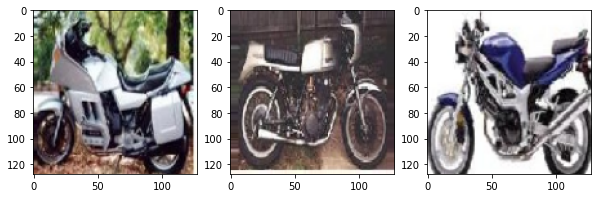

In [18]:
data = training_generator.__getitem__(1)

print(data[0].shape)
print(data[1].shape)

img = data[0]
plt.figure(figsize=(10,10))
for i in range(3):
    img = choice(data[0])
    plt.subplot(131+i)
    plt.imshow(img)

plt.show()


In [16]:

model = ResidualAttentionModel(input_shape, num_classes=num_classes)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

In [20]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=0, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=3,verbose=1,mode="max",min_lr=0.00001)
callbacks=[mc,es,rl]

In [21]:
history = model.fit(training_generator, epochs=35,
                              validation_data=validation_generator,callbacks=callbacks, verbose=1)

Epoch 1/35
173/173 [==============================] - 94s 475ms/step - loss: 2.3910 - accuracy: 0.3287 - val_loss: 2.2486 - val_accuracy: 0.1750

Epoch 00001: val_accuracy improved from -inf to 0.17502, saving model to top-weights.h5
Epoch 2/35
173/173 [==============================] - 42s 243ms/step - loss: 1.2799 - accuracy: 0.5344 - val_loss: 2.4270 - val_accuracy: 0.4052

Epoch 00002: val_accuracy improved from 0.17502 to 0.40523, saving model to top-weights.h5
Epoch 3/35
173/173 [==============================] - 42s 243ms/step - loss: 1.0640 - accuracy: 0.6340 - val_loss: 1.5264 - val_accuracy: 0.4829

Epoch 00003: val_accuracy improved from 0.40523 to 0.48293, saving model to top-weights.h5
Epoch 4/35
173/173 [==============================] - 42s 243ms/step - loss: 0.8809 - accuracy: 0.6927 - val_loss: 1.4068 - val_accuracy: 0.5890

Epoch 00004: val_accuracy improved from 0.48293 to 0.58896, saving model to top-weights.h5
Epoch 5/35
173/173 [==============================] - 4

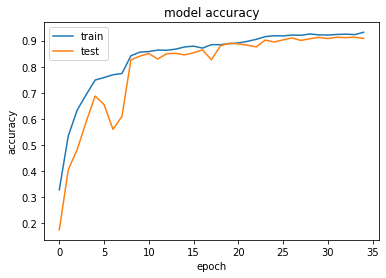

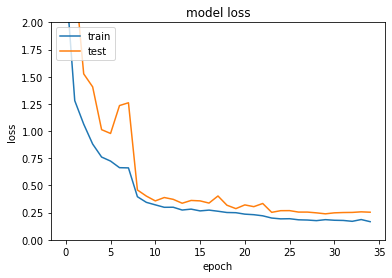

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim([0,2])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot mask layer impact

In [23]:
from tensorflow.keras import backend as K
layer1 = model.get_layer('mask_layer_op_1')
layer2 = model.get_layer('mask_layer_op_2')
layer3 = model.get_layer('mask_layer_op_3')

keras_function1 = K.function([model.input], [layer1.output])
keras_function2 = K.function([model.input], [layer2.output])
keras_function3 = K.function([model.input], [layer3.output])


In [25]:
data = validation_generator.__getitem__(1)[0]
data.shape

(32, 128, 128, 3)

In [206]:
res1 = np.array(keras_function1(data)[0])
res2 = np.array(keras_function2(data)[0])
res3 = np.array(keras_function3(data)[0])

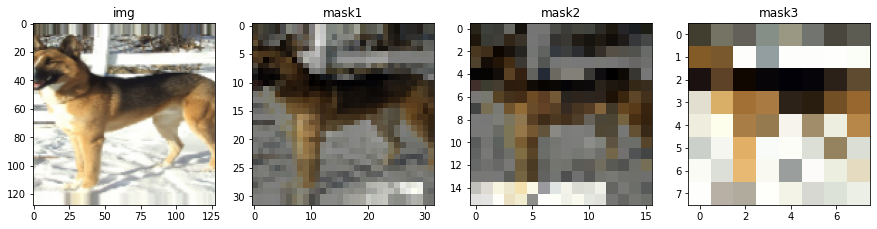

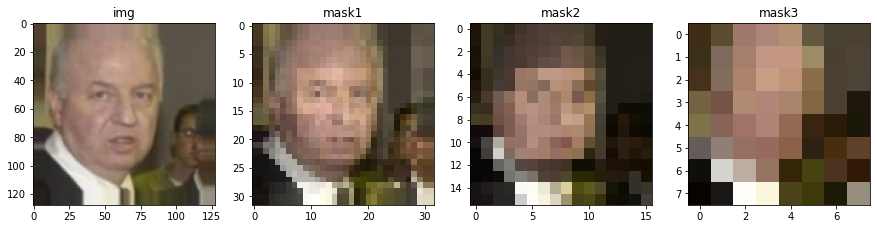

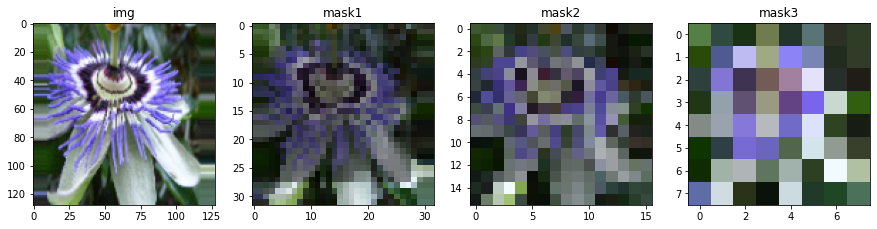

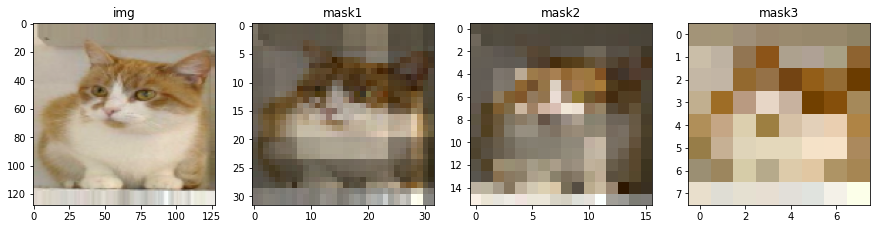

In [473]:
for i in range(0,4):
    plt.figure(figsize=(15,15))
    m1 = res1[3+i]
    m2 = res2[3+i]
    m3 = res3[3+i]

    img = data[3+i]
    plt.subplot(141)
    plt.title('img')
    plt.imshow((img*255).astype('uint8'))

    img1 = cv2.resize(img, m1.shape[:2])
    img1 = img1+img1*m1
    img1 = cv2.normalize(img1, img1, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.subplot(142)
    plt.title('mask1')
    plt.imshow((img1*255).astype('uint8'))

    img2 = cv2.resize(img, m2.shape[:2])
    img2 = img2+img2*m2
    img2 = cv2.normalize(img2, img2, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.subplot(143)
    plt.title('mask2')
    plt.imshow((img2*255).astype('uint8'))

    img3 = cv2.resize(img, m3.shape[:2])
    img3 = img3+img3*m3
    img3 = cv2.normalize(img3, img3, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.subplot(144)
    plt.title('mask3')
    plt.imshow((img3*255).astype('uint8'))

    plt.show()